In [1]:
import jax
import jax.numpy as jnp
from jax import jit, lax, random, vmap, grad, value_and_grad, hessian, jvp, vjp
from jax.config import config 

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from functools import partial
import sys

config.update("jax_debug_nans", True)

In [2]:
mode = 'stackgrad'

def save(results, app):
    if results == {}:
        for k in app.keys():
            results[k] = app[k]
    else:
        for k in app.keys():
            results[k] = np.concatenate((results[k], app[k]))
            
def derivatives(f1, f2):
    D1f1 = grad(f1, argnums=1)
    D2f1 = grad(f1, argnums=2)
    D2f2 = grad(f2, argnums=2)
    D1f2 = grad(f2, argnums=1)

    D11f1 = lambda r,x,y,**k: lambda v: jvp(lambda x: D1f1(r,x,y,**k), (x,), (v,))[1]
    D21f1 = lambda r,x,y,**k: lambda v: jvp(lambda y: D1f1(r,x,y,**k), (y,), (v,))[1]
    D12f1 = lambda r,x,y,**k: lambda v: jvp(lambda x: D2f1(r,x,y,**k), (x,), (v,))[1]
    D22f1 = lambda r,x,y,**k: lambda v: jvp(lambda y: D2f1(r,x,y,**k), (y,), (v,))[1]
    
    D11f2 = lambda r,x,y,**k: lambda v: jvp(lambda x: D1f2(r,x,y,**k), (x,), (v,))[1]
    D12f2 = lambda r,x,y,**k: lambda v: jvp(lambda x: D2f2(r,x,y,**k), (x,), (v,))[1]
    D21f2 = lambda r,x,y,**k: lambda v: jvp(lambda y: D1f2(r,x,y,**k), (y,), (v,))[1]
    D22f2 = lambda r,x,y,**k: lambda v: jvp(lambda y: D2f2(r,x,y,**k), (y,), (v,))[1]
    
    return dict(D1f1=D1f1, D2f2=D2f2, D1f2=D1f2, D2f1=D2f1, 
                D11f1=D11f1, D21f1=D21f1, D12f1=D12f1, D22f1=D22f1,
                D11f2=D11f2, D12f2=D12f2, D21f2=D21f2, D22f2=D22f2 )

def inv(f, reg):
    def func(w):
        def fn(v):
            return f(v) + reg*v
        return jax.scipy.sparse.linalg.cg(fn, w)[0]
    return func
def normal_log_prob(x, loc, scale):
    log_unnormalized = -0.5 * (x-loc)**2/scale**2
    log_normalization = 0.5 * np.log(2.*np.pi) + jnp.log(scale)
    return log_unnormalized - log_normalization

def linear_quadratic_two_player(A, B1, B2, Q1, Q2, R11, R12, R21, R22):
    """ Generator for linear state dynamics and quadratic costs. """
    n_state = A.shape[0]
    n_act1 = B1.shape[1]
    n_act2 = B2.shape[1]
    
    assert A.shape[0] == A.shape[1], "A must be square"
    assert B1.shape == (n_state, n_act1), "B1 is in the wrong shape"
    assert B2.shape == (n_state, n_act2), "B2 is in the wrong shape"
    assert R11.shape == (n_act1, n_act1), "R11 is in the wrong shape"
    assert R12.shape == (n_act2, n_act2), "R12 is in the wrong shape"
    assert R21.shape == (n_act1, n_act1), "R21 is in the wrong shape"
    assert R22.shape == (n_act2, n_act2), "R22 is in the wrong shape"
    assert Q1.shape == (n_state, n_state), "Q1 is in the wrong shape"
    assert Q2.shape == (n_state, n_state), "Q2 is in the wrong shape"
    
    K1 = jnp.zeros(B1.shape).T
    K2 = jnp.zeros(B2.shape).T
    
    def state_dynamics(state, rng, policies, act_std1, act_std2):
        noise = random.normal(rng, (n_act1+n_act2,))
        w1, w2 = noise[:n_act1], noise[n_act1:]
        K1, K2 = policies
        
        act1 = K1@state + w1*act_std1
        act2 = K2@state + w2*act_std2

        state = A@state + B1@act1 + B2@act2 

        cost1 = state.T@Q1@state + act1.T@R11@act1 + act2.T@R12@act2
        cost2 = state.T@Q2@state + act1.T@R21@act1 + act2.T@R22@act2
        
        state_ = lax.stop_gradient(state)
        act1_ = lax.stop_gradient(act1)
        act2_ = lax.stop_gradient(act2)
        
        logp1 = normal_log_prob(K1@state_, loc=act1_, scale=act_std1)
        logp2 = normal_log_prob(K2@state_, loc=act2_, scale=act_std2)
        
        info = dict(state=state,
                    costs=(cost1, cost2), 
                    actions=(act1, act2),
                    logp=(logp1, logp2))
        
        return state, info
    
    return state_dynamics, (K1, K2)


def batch_policy_gradient(dynamics, n_horizon:int, n_samples:int, sample_mode:str):
    """ Two modes supported: exact and logprob """

    def sample_logp(rng, K1, K2, T=n_horizon, **kwargs):
        """ Sample total costs from one trajectory """
        rngs = random.split(rng, T+1)
        x0 = random.normal(rng, (K1.shape[1],))
        _, res = lax.scan(partial(dynamics, policies=(K1, K2), **kwargs), x0, rngs)
        cost1 = lax.stop_gradient(res['costs'][0])
        cost2 = lax.stop_gradient(res['costs'][1])
        logp1, logp2 = res['logp']

        return (cost1*logp1).mean(), (cost2*logp2).mean()

    def sample_exact(rng, K1, K2, T:int=n_horizon, **kwargs):
        """ Sample total costs from one trajectory """
        rngs = random.split(rng, T+1)
        x0 = random.normal(rng, (K1.shape[1],))
        _, res = lax.scan(partial(dynamics, policies=(K1, K2), **kwargs), x0, rngs)
        cost1 = res['costs'][0]
        cost2 = res['costs'][1]

        return cost1.mean(), cost2.mean()

    if sample_mode == 'logprob':
        sample = sample_logp
    elif sample_mode == 'exact':
        sample = sample_exact
    else:
        assert False, "sample mode '{}' not supported".format(sample_mode)

    def samples1(rng, K1, K2, N:int=n_samples, **kwargs):
        """ Sample average total costs from N trajectories (player 1) """
        rngs = random.split(rng, N)
        loss1, loss2 = vmap(partial(sample, K1=K1, K2=K2, **kwargs))(rngs)
        return loss1.mean()

    def samples2(rng, K1, K2, N:int=n_samples, **kwargs):
        """ Sample average total costs from N trajectories (player 2) """
        rngs = random.split(rng, N)
        loss1, loss2 = vmap(partial(sample, K1=K1, K2=K2, **kwargs))(rngs)
        return loss2.mean()

#    D1f1 = value_and_grad(samples1, argnums=1)
#    D2f2 = value_and_grad(samples2, argnums=2)

    return samples1, samples2

def batch_grad(game_form, n_iters:int):
    
    def grad(policies, rng, lr1, lr2, **kwargs):
        K1, K2 = policies
        g1, g2 = game_form(rng, K1, K2, **kwargs)
        
       #loss1, g1 = D1f1(rng, K1, K2, **kwargs)
       #loss2, g2 = D2f2(rng, K1, K2, **kwargs)

        K1 = K1 - lr1*g1
        K2 = K2 - lr2*g2

        info = dict(K1=K1, K2=K2, 
#                     loss1=loss1, loss2=loss2,
                    gradnorm1=jnp.linalg.norm(g1), 
                    gradnorm2=jnp.linalg.norm(g2))
        return (K1, K2), info

    def multi_step(rng, policies, N=n_iters, **kwargs):
        rngs = random.split(rng, N)
        policies, res = lax.scan(partial(grad, **kwargs), policies, rngs)
        return policies, res
    
    return jit(multi_step)

def simgrad(r,x,y,**k):
    return (D1f1(r,x,y,**k), D2f2(r,x,y,**k))

def stack(r,x,y,**k):
    return (D1f1(r,x,y,**k), \
            D2f2(r,x,y,**k) 
            - D12f2(r,x,y,**k)(inv(D22f2(r,x,y,**k), reg=reg)(D2f1(r,x,y,**k))))

I = np.eye(2)
Ib = np.ones((2,1))
Ia = np.ones((1,1))
A = 0.9*I
B1, B2 = .2*Ib, .05*Ib
Q, R1, R2 = 10*I, 1*Ia, -.5*Ia

sys1_zs_params = dict(A=A, B1=B1, B2=B2, Q1=Q, Q2=-Q, 
                      R11=R1, R12=R2, R21=-R1, R22=-R2)
batch_pg_params = dict(n_horizon=15, n_samples=32)
batch_grad_params = dict(n_iters=64)

state_dynamics, init_profile = linear_quadratic_two_player(**sys1_zs_params)
losses_e = batch_policy_gradient(state_dynamics, 
                               sample_mode='exact', **batch_pg_params)
game_form_e = derivatives(*losses_e)

D1f1, D2f2 = game_form_e['D1f1'], game_form_e['D2f2']
D12f2, D22f2 = game_form_e['D12f2'], game_form_e['D22f2']
D2f1 = game_form_e['D2f1']

def simgrad(r,x,y,**k):
    return (D1f1(r,x,y,**k), D2f2(r,x,y,**k))

def stack(r,x,y,stack_reg=0,**k):
    return (D1f1(r,x,y,**k), \
            D2f2(r,x,y,**k) 
            - D12f2(r,x,y,**k)(inv(D22f2(r,x,y,**k), reg=stack_reg)(D2f1(r,x,y,**k))))

if mode=='simgrad': multi_step_exact = batch_grad(simgrad, **batch_grad_params)
if mode=='stackgrad': multi_step_exact = batch_grad(stack, **batch_grad_params)

rng = random.PRNGKey(0)
dynam_params = dict(act_std1=.1, act_std2=.1)
learn_params = dict(lr1=1e-4, lr2=1e-4, stack_reg=1)
print('Compiling...')
%time _ = multi_step_exact(rng, init_profile, **dynam_params, **learn_params)
# %time _ = multi_step_logprob(rng, init_profile, **dynam_params, **learn_params)
print('done.')
    

Compiling...
CPU times: user 20 s, sys: 354 ms, total: 20.4 s
Wall time: 20.5 s
done.


In [3]:
seed = 0
n_epoch = 100
dynam_params = dict(act_std1=.5, act_std2=.5)
learn_params = dict(lr1=1e-2, lr2=1e-2, stack_reg=10000)
K1, K2 = init_profile
policies_e = K1, K2
# policies_l = K1, K2
        
print('Running gradient sampling ')
rng = random.PRNGKey(seed)
rngs = random.split(rng, n_epoch)
results_e = dict()
# results_l = dict()
for epoch,rng in enumerate(rngs):
    policies_e, res_e = multi_step_exact(rng, policies_e,  **dynam_params, **learn_params)
#     policies_l, res_l = multi_step_logprob(rng, policies_l,  **dynam_params, **learn_params)
    sys.stdout.write('\rEpoch: {}/{}'.format(epoch+1, n_epoch))
    save(results_e, res_e)
#     save(results_l, res_l)

Running gradient sampling 
Epoch: 100/100

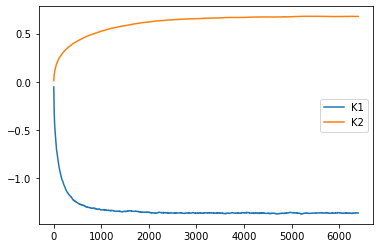

In [4]:
plt.plot(results_e['K1'][:,0,1], label="K1")
plt.plot(results_e['K2'][:,0,1], label="K2")
plt.legend()

In [5]:
dynamics, init_profile = linear_quadratic_two_player(**sys1_zs_params)
game_form_exact = batch_policy_gradient(state_dynamics, 
                                        sample_mode='exact', **batch_pg_params)


n_horizon = 15
def sample_exact(rng, K1, K2, T:int=n_horizon, **kwargs):
    """ Sample total costs from one trajectory """
    rngs = random.split(rng, T+1)
    x0 = random.normal(rng, (K1.shape[1],))
    _, res = lax.scan(partial(dynamics, policies=(K1, K2), **kwargs), x0, rngs)
    cost1 = res['costs'][0]
    cost2 = res['costs'][1]
    return cost1.mean(), cost2.mean()

def f1(rng, *policy):
    cost1, cost2 = sample_exact(rng, *policy, act_std1=1, act_std2=1)
    return cost1

def f2(rng, *policy):
    cost1, cost2 = sample_exact(rng, *policy, act_std1=1, act_std2=1)
    return cost2




In [6]:
rng = random.PRNGKey(0)
x1, x2 = init_profile
x = (x1, x2)

def stack2(r,x,y):
    return (D1f1(r,x,y) - D21f1(r,x,y)(inv(D11f1(r,x,y), reg=reg)(D1f2(r,x,y))), \
            D2f2(r,x,y))

def symplectic(r,x,y):
    return (D1f1(r,x,y) - align*(D12f1(r,x,y)(D2f2(r,x,y)) - D12f2(r,x,y)(D2f2(r,x,y))), \
            D2f2(r,x,y) - align*(D21f2(r,x,y)(D1f1(r,x,y)) - D21f1(r,x,y)(D1f1(r,x,y))))

def consensus(r,x,y):
    return (D1f1(r,x,y) - alpha*(D11f1(r,x,y)(D1f1(r,x,y)) + D12f2(r,x,y)(D2f2(r,x,y))), \
            D2f2(r,x,y) - alpha*(D22f2(r,x,y)(D2f2(r,x,y)) + D21f1(r,x,y)(D1f1(r,x,y))))

def gradconj(r,x,y):
    return (D1f1(r,x,y) - lr*D12f2(r,x,y)(D2f1(r,x,y)), \
            D2f2(r,x,y) - lr*D21f1(r,x,y)(D1f2(r,x,y)))
  
def fastconj(r,x,y):
    return (D1f1(r,x,y) - lr*D12f1(r,x,y)(D2f2(r,x,y)), \
            D2f2(r,x,y) - lr*D21f2(r,x,y)(D1f1(r,x,y)))

# J1 = lambda v,x1,x2,eta: v - eta**2*D12f1(x1,x2)(D21f2(x1,x2)(v)) 
# J2 = lambda v,x1,x2,eta: v - eta**2*D21f2(x1,x2)(D12f1(x1,x2)(v))
# def competitive(x1,x2, eta=0.1):
#     _J1 = partial(J1, x1=x1, x2=x2, eta=eta)
#     _J2 = partial(J2, x1=x1, x2=x2, eta=eta)
#     x1 = inv(_J1, reg=0, _x0=x1)(D1f1(x1,x2) - eta*D12f1(x1,x2)(D2f2(x1,x2)))
#     x2 = inv(_J2, reg=0, _x0=x2)(D2f2(x1,x2) - eta*D21f2(x1,x2)(D1f1(x1,x2)))
#     return [x1, x2]

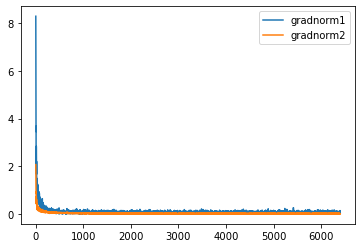

In [7]:
plt.plot(results_e['gradnorm1'].flatten(), label="gradnorm1")
plt.plot(results_e['gradnorm2'].flatten(), label="gradnorm2")
plt.legend()